In [17]:
import sys
sys.path.append('../..')
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import torchvision
from DLBio.pytorch_helpers import get_device

import numpy as np
import matplotlib.pyplot as plt
import ds_ear_siamese
import transforms_data as td
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss
from torch import cuda
from NN_Siamese import SiameseNetwork

In [18]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [28]:
# Set Up All Configurations here
class Config():
    dataset_dir = '../dataset_low_res/'
    # training_dir = "../data/ears/training/"
    # testing_dir = "../data/ears/testing/"
    train_batch_size = 32
    test_batch_size = 1
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS= 50
    LEARNINGRATE = 0.0005
    WEIGHT_DECAY = 0.1

In [29]:
# define indicies to split Data
N = len(ds_ear_siamese.get_dataset(data_path=Config.dataset_dir, transform_mode='size_only'))
print(N)
n_80 = int(round(.8*N))
n_70 = int(round(.7*N))
n_60 = int(round(.6*N))

rand_indices = np.random.permutation(N)
train_indices = rand_indices[:n_70]
test_indices = rand_indices[n_70:]

# definde data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = ds_ear_siamese.get_dataloader(
    indices=train_indices,
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese', # TODO switch to another transform? 
    data_path=Config.dataset_dir
)

# dl_test = ds_ear_siamese.get_dataloader(
test_dataloader = ds_ear_siamese.get_dataloader(
    indices=test_indices,
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    data_path=Config.dataset_dir
)

vis_dataloader = ds_ear_siamese.get_dataloader(
    indices=train_indices,
    batch_size=Config.vis_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    data_path=Config.dataset_dir
)

['alissa_buh', 'falco_len', 'gregor_spi', 'janna_qua', 'jesse_kru', 'johannes_boe', 'johannes_wie', 'konrad_von', 'mila_wol', 'nils_loo', 'sarah_feh', 'tim_moe']
847


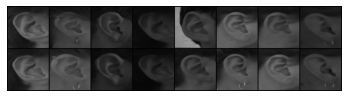

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [31]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [32]:
# Definde Model and load to device
#model = mobilenet_v2(pretrained=False)
#model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=5)
model = SiameseNetwork()


device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss()
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)

cuda:0


Epoch number 0
 Current loss 2.3565421104431152

Epoch number 0
 Current loss 8.813267707824707

Epoch number 1
 Current loss 3.2995169162750244

Epoch number 1
 Current loss 1.10329008102417

Epoch number 2
 Current loss 2.469986915588379

Epoch number 2
 Current loss 0.9989994764328003

Epoch number 3
 Current loss 1.4402809143066406

Epoch number 3
 Current loss 1.5131518840789795

Epoch number 4
 Current loss 1.7556205987930298

Epoch number 4
 Current loss 0.5006223320960999

Epoch number 5
 Current loss 1.3872108459472656

Epoch number 5
 Current loss 0.4104061722755432

Epoch number 6
 Current loss 0.8255057334899902

Epoch number 6
 Current loss 1.0695598125457764

Epoch number 7
 Current loss 1.259089469909668

Epoch number 7
 Current loss 0.8875640034675598

Epoch number 8
 Current loss 1.269240379333496

Epoch number 8
 Current loss 0.42063629627227783

Epoch number 9
 Current loss 1.0147265195846558

Epoch number 9
 Current loss 1.1254656314849854

Epoch number 10
 Current 

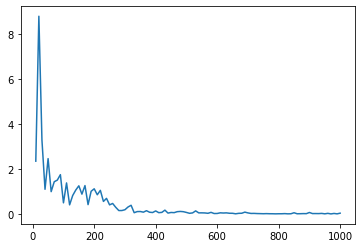

In [33]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, 
                loss_contrastive=contrastive_loss_siamese)

counter, loss_history = training(Config.EPOCHS)
show_plot(counter, loss_history)

In [34]:
#Output for NN
def generate_output( img_in, img_in2):
    if cuda.is_available():
        return model(Variable(img_in).cuda(), Variable(img_in2).cuda())
    else:
        return model(Variable(img_in))

# Output for Mobilenet
# def generate_output( img_in):
#     if cuda.is_available():
#         return model(Variable(img_in).cuda())
#     else:
#         return model(Variable(img_in))         

In [35]:
iter_batches = iter(test_dataloader)

accuracy_count = 0.0
matches = []
non_matches = []
for i in range(len(iter_batches)):
    # batch size schould be 1 to throw no errors in accessing the next(iter_batches) 
    img0, img1, label = next(iter_batches)
    # appends images to matches, if label is 0 (0 = same)
    ((matches, non_matches)[int(label)]).append( (img0,img1) )

# iterate through both lists and compare the distances of the current entries
for m, n in zip(matches, non_matches):
    # get the models output vectors for the images
    match_out1, match_out2 = generate_output(m[0], m[1])
    non_match_out1, non_match_out2 = generate_output(n[0], n[1])
    #match_out1 = generate_output(m[0])
    #match_out2 = generate_output(m[1])                 NEED TO BE CHANGED FOR MOBILENET
    #non_match_out1 = generate_output(n[0])
    #non_match_out2 = generate_output(n[1])
    
    # positive-positive, positive-negative distance
    euclidean_distance_pp = F.pairwise_distance(match_out1, match_out2)
    euclidean_distance_pn = F.pairwise_distance(non_match_out1, non_match_out2)
    
    # format variables
    fmt_id = '{:<12}'
    fmt_eucl = '{:<.3f}'
    # increase accouracy count if p-p was lower than p-n
    if(euclidean_distance_pp < euclidean_distance_pn): accuracy_count += 1
    # print current stats
    print(fmt_id.format('pos-pos: '), fmt_eucl.format( euclidean_distance_pp.item()) )
    print(fmt_id.format('pos-neg: '),fmt_eucl.format( euclidean_distance_pn.item()) )
    print(fmt_id.format('Acc. count: '), '{:>.0f}'.format(accuracy_count), '\n')

# divide by the minimum length (zip function regulated the steps to the minimum)
print(fmt_id.format('Overall (estimated) accuracy: '), fmt_eucl.format(accuracy_count / min(len(matches), len(non_matches)) ), ' %')

pos-pos:     0.455
pos-neg:     1.558
Acc. count:  1 

pos-pos:     0.431
pos-neg:     3.892
Acc. count:  2 

pos-pos:     0.272
pos-neg:     2.516
Acc. count:  3 

pos-pos:     0.401
pos-neg:     3.554
Acc. count:  4 

pos-pos:     0.280
pos-neg:     3.612
Acc. count:  5 

pos-pos:     0.204
pos-neg:     1.768
Acc. count:  6 

pos-pos:     0.353
pos-neg:     3.938
Acc. count:  7 

pos-pos:     0.165
pos-neg:     2.697
Acc. count:  8 

pos-pos:     0.126
pos-neg:     2.051
Acc. count:  9 

pos-pos:     0.818
pos-neg:     2.009
Acc. count:  10 

pos-pos:     0.220
pos-neg:     3.024
Acc. count:  11 

pos-pos:     0.713
pos-neg:     2.898
Acc. count:  12 

pos-pos:     1.264
pos-neg:     1.942
Acc. count:  13 

pos-pos:     0.392
pos-neg:     3.222
Acc. count:  14 

pos-pos:     0.603
pos-neg:     3.269
Acc. count:  15 

pos-pos:     0.244
pos-neg:     1.944
Acc. count:  16 

pos-pos:     0.128
pos-neg:     2.356
Acc. count:  17 

pos-pos:     0.192
pos-neg:     1.778
Acc. count:  18 

p

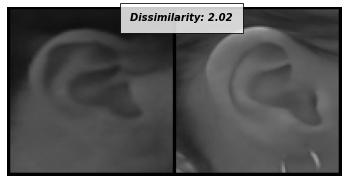

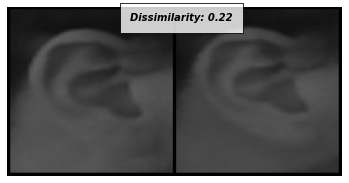

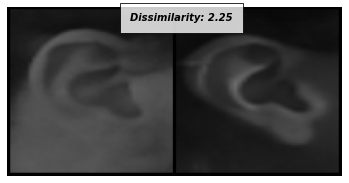

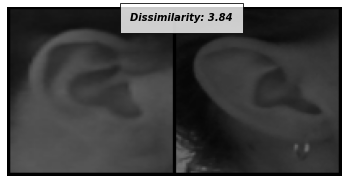

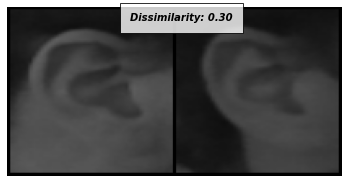

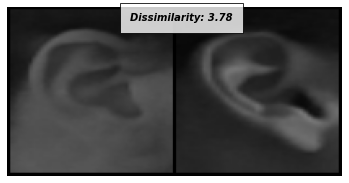

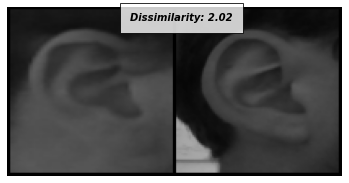

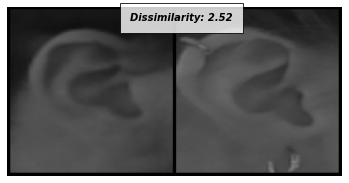

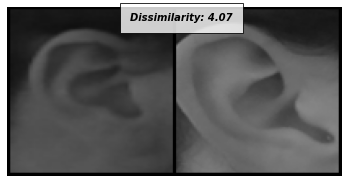

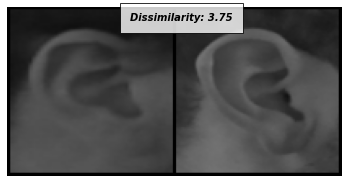

In [42]:
# Show for NN
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = model(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

# Show for Mobilenet
# unnormalize = td.UnNormalize()
# dataiter = iter(test_dataloader)
# for i in range(10):
#     x0,x1,label = next(dataiter)
#     concatenated = torch.cat((unnormalize(x0), unnormalize(x1)),0)
#     if cuda.is_available():
#         output1 = model(Variable(x0).cuda())
#         output2 = model(Variable(x1).cuda())
#     else:
#         output1 = model(Variable(x0))
#         output2 = model(Variable(x1))
#     euclidean_distance = F.pairwise_distance(output1, output2)
#     imshow(make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [12]:
#model = torch.load('/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')

In [37]:
torch.save(model,'/nfshome/lentzsch/Documents/Bachelorarbeit/Bachelorthesis/models/model.pt')